In [ ]:
########## INSTALLATION AND SETUP ##########
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install -q pyspark

!pip install gdelt

!pip install pycountry
!pip install geopandas

import pyspark, os
from pyspark import SparkConf, SparkContext
os.environ["PYSPARK_PYTHON"]="python3"
os.environ["JAVA_HOME"]="/usr/lib/jvm/java-8-openjdk-amd64/"

#start spark local server
import sys, os
from operator import add
import time

os.environ["PYSPARK_PYTHON"]="python3"

import pyspark
from pyspark import SparkConf, SparkContext

# Connects our python driver to a local Spark JVM running on the Google Colab server virtual machine
try:
  conf = SparkConf().setMaster("local[1]").set("spark.executor.memory", "1g")
  sc = SparkContext(conf = conf)
except ValueError:
  #it's ok if the server is already started
  pass

def dbg(x):
  """ A helper function to print debugging information on RDDs """
  if isinstance(x, pyspark.RDD):
    print([(t[0], list(t[1]) if 
            isinstance(t[1], pyspark.resultiterable.ResultIterable) else t[1])
           if isinstance(t, tuple) else t
           for t in x.take(100)])
  else:
    print(x)

# Other Imports
from concurrent.futures import ProcessPoolExecutor
from datetime import date, timedelta
import pandas as pd
import gdelt
import os

from pyspark.sql import SQLContext
from pyspark.sql.types import StructType, StructField, StringType
from pathlib import Path

from urllib.parse import urlparse

from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.sql.functions import udf

import pycountry 
import geopandas
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:15 http://ppa.launchpad.net/graph

**Preperation to pull data from GDELT**

In [ ]:
#Start timer
time_start = time.time()

In [ ]:
########## PULLING DATA FROM GDELT ##########
TestDate = '2021 may 30' # End date
days = 92 # Number of days before end date to use
allData = False # boolean for grabbing all data from each day


# set up gdeltpyr for version 2
gd = gdelt.gdelt(version=2)

# multiprocess the query
e = ProcessPoolExecutor()

# generic functions to pull and write data to disk based on date
def get_filename(x):
  date = x.strftime('%Y%m%d')
  return "{}_gdeltdata.csv".format(date)


def intofile(filename):
    try:
        if not os.path.exists(filename):
          date = filename.split("_")[0]
          d = gd.Search(date, table='gkg',coverage=allData)
          d.to_csv(filename,encoding='utf-8',index=False)
    except:
        print("Error occurred")

# pull the data from gdelt into multiple files
# Pulling all data from a single day.

recentDates = [get_filename(x) for x in pd.date_range(end=TestDate,periods=days)]
results = list(e.map(intofile,recentDates))

/usr/local/lib/python3.7/dist-packages/gdelt/parallel.py:103: UserWarning: GDELT did not return data for date time 20210323234500
  warnings.warn(message)


Error occurred


/usr/local/lib/python3.7/dist-packages/gdelt/parallel.py:103: UserWarning: GDELT did not return data for date time 20210309234500
  warnings.warn(message)


Error occurred


/usr/local/lib/python3.7/dist-packages/gdelt/parallel.py:103: UserWarning: GDELT did not return data for date time 20210327234500
  warnings.warn(message)


Error occurred


/usr/local/lib/python3.7/dist-packages/gdelt/parallel.py:103: UserWarning: GDELT did not return data for date time 20210324234500
  warnings.warn(message)


Error occurred


/usr/local/lib/python3.7/dist-packages/gdelt/parallel.py:103: UserWarning: GDELT did not return data for date time 20210408234500
  warnings.warn(message)


Error occurred


/usr/local/lib/python3.7/dist-packages/gdelt/parallel.py:103: UserWarning: GDELT did not return data for date time 20210411234500
  warnings.warn(message)


Error occurred


/usr/local/lib/python3.7/dist-packages/gdelt/parallel.py:103: UserWarning: GDELT did not return data for date time 20210426234500
  warnings.warn(message)


Error occurred


/usr/local/lib/python3.7/dist-packages/gdelt/parallel.py:103: UserWarning: GDELT did not return data for date time 20210412234500
  warnings.warn(message)


Error occurred


/usr/local/lib/python3.7/dist-packages/gdelt/parallel.py:103: UserWarning: GDELT did not return data for date time 20210526234500
  warnings.warn(message)


Error occurred


/usr/local/lib/python3.7/dist-packages/gdelt/parallel.py:103: UserWarning: GDELT did not return data for date time 20210505234500
  warnings.warn(message)


Error occurred


In [ ]:
########## LOAD GDELT DATA INTO SQLCONTEXT ##########

sqlContext = SQLContext(sc)

# only includes files which successfully pulled from GDELT
goodFiles = []
for path in recentDates:
  if ((Path.cwd() / path).exists()):
    goodFiles.append(path)

# Read the CSVs and combine into a single dataframe
recentData = sqlContext.read.option("header", "true").csv(goodFiles)

# Read the geographic source lookup file and store as dataframe
gsl = sqlContext.read.option("header", "true").csv('/content/drive/MyDrive/Projects/GDELT/GSL.TXT', sep="	", header="false",
                                                   schema=StructType(
                                                       [
                                                        StructField("source", StringType()), 
                                                        StructField("countryCode", StringType())
                                                      ])
                                                  )


In [ ]:
########## SELECTING DATA COLUMNS AND LOADING INTO RDD ##########

# Extract columns to work with into rdds

# Gets the country code
def getCountryCode(Location):
  countryCode = "NA"
  if Location != None:
    countryCode = Location.split("#")[2]
  return(countryCode)

# Gets the tone
def getTone(V2Tone):
  tone = "NA"
  if V2Tone != None:
    tone = V2Tone.split(',')[0]
  return(tone)

# Get the source url, country code of the location documented, and the tone of the documents
selected = recentData.rdd.map(lambda row: ((urlparse(row['DocumentIdentifier']).netloc,
                                              (urlparse(row['DocumentIdentifier']).netloc,
                                              getCountryCode(row['Locations']),
                                              getTone(row['V2Tone'])
                                              ))
                                          ))

# store gsl into rdd
gsl = gsl.rdd 

In [ ]:
########## RDD MANIPULATION ##########

# joining the two rdds on source (the keys)
joined = selected.join(gsl)

# finding all the countries involved in the dataset
sources = joined.map(lambda x: x[1][1]).distinct()
targets = joined.map(lambda x: x[1][0][1]).distinct()

# Getting all the countries involved, both sources and targets
countries = sources.union(targets)
countries = countries.distinct().sortBy(lambda x: x)


# Creates a cross product of all countries involved. This ensures every country pair exists, and in both directions.
# Then give each country pair a default value of (0,0).
# This represents a default of 0 average tone and 0 documents.
allCountryPairs = countries.cartesian(countries).map(lambda x: (x, (0,0)))

# Take and format the joined rdd to form:
# (sourceCountry, target), (tone, 1)
def format(row):
  sourceCountry = row[1][1]
  target = row[1][0][1]
  tone = row[1][0][2]
  return((sourceCountry, target), (tone, 1))

# Format the rdd and union it with the default values.
joinedFormatted = joined.map(format).union(allCountryPairs)

# Aggregate the formatted joined rdd by summing all tones and document counts.
# NB the conversion of the tone strings to floats 
aggregate = joinedFormatted.aggregateByKey((0, 0), lambda a,b: (a[0]+float(b[0]), a[1]+b[1]), lambda a,b: (a[0]+b[0], a[1]+b[1]))

# Since some country pairs have 0 documents between them, simply averaging the tones by the 
# document counts results in some division by 0 errors.
# To avoid this, the below code simply applies a 0.0 average tone if no documents exist for a given pair
def avoidDivisonByZero(pair):
  (totalTone, totalDocuments) = pair
  if totalDocuments == 0:
    return 0.0
  else:
    return totalTone/totalDocuments

# Average the tones by total documents
averagedAgg = aggregate.mapValues(avoidDivisonByZero)

# averagedAgg is now of form (source, target), averageTone.

# Reformat the rdd to have the source country as key and the target country
# as the first element of the value tuple.
# Then, group the data and convert the values rdd list into a python list.
# Finally, sort those lists.
sortedRD = averagedAgg.map(lambda x: (x[0][0], (x[0][1], x[1]))).groupByKey().mapValues(list).mapValues(lambda x: sorted(x)) # Python automatically sorts by first element

# sortedRD is an array of key value pairs where:
# Key = source country
# Value = list of (country, averageTone) sorted by country code.

########## SORTING TEST ##########
test = False # boolean for running test or skipping it

# The country codes are unique. 
# If the country codes are concatenated, each ordering of countries will form its own unique string. 
# If our sorting method worked, there will be only one unique string.

if test:
  # Get the country codes out and concatenate them into a single string
  def getFirst(inList):
    out = ''
    for (cc, _) in inList:
      out += cc
    return out
  # obtain an rdd with the concatenated target country code strings for every source country
  targetLists = sortedRD.mapValues(getFirst).flatMap(lambda x:[x[1]])

  # Ensure that the unique target concat list size are equal to 1
  # if the unique count is 1, then all the lists have their countries in the same order

  assert targetLists.distinct().count() == 1
  dbg(targetLists.distinct().count())
########## END TEST ##########

# Extracts only the tones
def getTonesOnly(valueList):
  retList = []
  for (_, tone) in valueList:
    retList.append(tone)
  return retList

# Return True if a list of tones has a non-zero value in it
def prune(tones):
  if all([ tone == 0.0 for tone in tones ]):
    return False
  else:
    return True

# Removes the target country codes from the values list, and prunes away the 
# countries with length 0 vectors.
# Cosine similarity algorithms fail with 0 length vectors, therefore the pruning is necessary.
tonesOnly = sortedRD.mapValues(getTonesOnly).filter(lambda x: prune(x[1]))

In [ ]:
time_rdd = time.time()

In [ ]:
########## CONVERT RDD TO SQLCONTEXT ##########

# Convert the rdd into a dataframe with columns "source" and "features"
df = sqlContext.createDataFrame(tonesOnly)
df = df.selectExpr("_1 as source", "_2 as tones")

In [ ]:
time_toDF = time.time()

In [ ]:
########## CLUSTERING ##########

# new_schema converts the column of tones into a type compatible with pyspark's
# k-means implementation.
new_schema = ArrayType(DoubleType(), containsNull=False)
bruh = udf(lambda x:x, new_schema)
df = df.withColumn("tones",bruh("tones"))
df.cache()
 
# Create the evaluator to see clustering effectiveness
evaluator = ClusteringEvaluator(featuresCol='tones')

########## FINDING BEST K ##########
tryList = [2,3,4,5]


best = [-2, -1, None] # silhouette, k, prediction
for i in tryList:
  kmeans = KMeans(featuresCol='tones').setDistanceMeasure('cosine').setK(i)
  model = kmeans.fit(df)
  predictions = model.transform(df)
 
  silhouette = evaluator.setDistanceMeasure('cosine').evaluate(predictions)

  # If silhouette is better than the current best prediction, update "best"
  if(silhouette > best[0]):
    best = [silhouette, i, predictions]
  print("K = " + str(i) + ' :' + "Silhouette = " + str(silhouette))

bestPrediction = best[2]
print("Best K = " + str(best[1]) + ' :' + "Silhouette = " + str(best[0]))

K = 2 :Silhouette = 0.06616928825665112
K = 3 :Silhouette = 0.04555941718670955
K = 4 :Silhouette = 0.02812538602947695
K = 5 :Silhouette = 0.03318724208739574
Best K = 2 :Silhouette = 0.06616928825665112


In [ ]:
time_clustering = time.time()

74


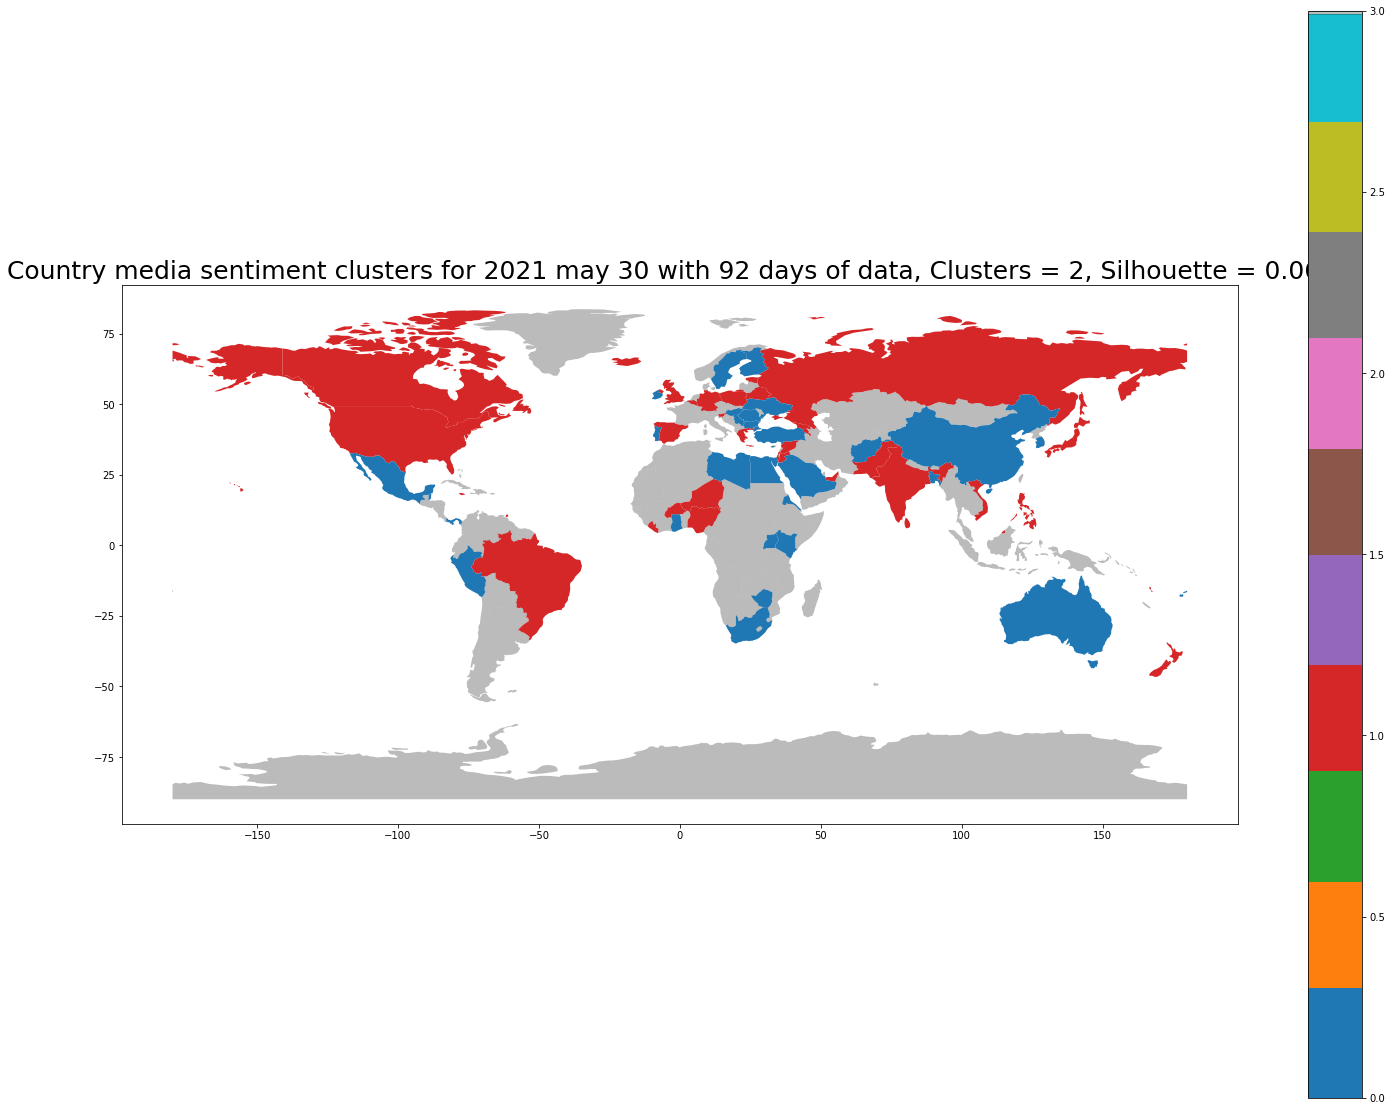

In [ ]:
########## PLOT DATA ##########

# Take the source and predictions column from the best prediction model.
# Then convert to a pandas dataframe.
data = bestPrediction.select('source', 'prediction').toPandas()
data = data.astype({"source": 'string', "prediction": 'int64'})
print(len(data.index))

# Grab supplementary dataset which maps FIPS 10-4 codes to ISO 3166 Alpha 2
codes = pd.read_csv('https://raw.githubusercontent.com/mysociety/gaze/master/data/fips-10-4-to-iso-country-codes.csv')
codes = codes.rename(columns={'FIPS 10-4': 'source', 'ISO 3166': 'iso', 'Name':'namey'})
codes = codes.astype('string')

# Join the clustering df with the codes df
df = data.merge(codes)

# Using pycountry, convert the alpha 2 country codes to alpha 3
def alpha3code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(alpha_2=country).alpha_3
           # .alpha_3 means 3-letter country code 
           # .alpha_2 means 2-letter country code
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE
# create a column for code 
df['a3']=alpha3code(df['iso'])


# The below code was influenced by/copied from a tutorial online https://melaniesoek0120.medium.com/data-visualization-how-to-plot-a-map-with-geopandas-in-python-73b10dcd4b4b

# Get the geopandas data set "naturalearth_lowres"
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# Rename the columns so that we can merge with our data.
# The main column of interest is 'a3' which we merge on.
world.columns=['pop_est', 'continent', 'name', 'a3', 'gdp_md_est', 'geometry']

# Then merge with our data using an outer join to keep all countries
merge=pd.merge(world,df,on='a3',how='outer')

# If there are NaNs in the prediction column, it is because the country wasn't a source country
# in the data pulled from gdelt.
# We give them a dummy prediction of cluster value (cluster count + 1).
# This 'cluster' group will be coloured grey.
merge = merge.fillna({'prediction': best[1] + 1})

# Custom colour palette with the highest color value being grey.
# This colours our NaN group grey.
tab = cm.get_cmap('tab10', 256)
newcolors = tab(np.linspace(0, 1, 256))
grey = np.array([30/256, 30/256, 30/256, 0.3])

newcolors[255:256, :] = grey
newcmp = ListedColormap(newcolors)

# Plot countries, colouring them based on their predicted cluster. If prediction was
# NaN, colour them grey.
merge.plot(column='prediction', 
           figsize=(25, 20),
           legend=True,cmap=newcmp)
plt.title('Country media sentiment clusters for ' + TestDate + ' with '+ str(days) + ' days of data, Clusters = ' + str(best[1]) + ', Silhouette = ' + str(round(best[0], 4)),fontsize=25)
plt.show()

In [ ]:
time_end = time.time()

In [ ]:
print("Total time taken was %s" % str(time_end-time_start))

print("End date: " + TestDate)
print("Days used: " + str(days))
print("Rows of Data: " + str(recentData.count()))

print("Best K = " + str(best[1]) + ' :' + "Silhouette = " + str(best[0]))

Total time taken was 502.24288511276245
End date: 2021 may 30
Days used: 92
Rows of Data: 117355
Best K = 2 :Silhouette = 0.06616928825665112
